## Overall GLCM Texture Features across each modality (Real, GANs, Diffusion)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

# Paths
real_paths = ["../data/BEST/bedroom/real_200x200", "../data/BEST/face/real", "../data/BEST/imagenet/real_imagenet"]
gan_paths = ["../data/BEST/bedroom/gansformer", "../data/BEST/face/stylegan2", "../data/BEST/imagenet/big_gan"]
diff_paths = ["../data/BEST/bedroom/ddpm", "../data/BEST/face/palette", "../data/BEST/imagenet/vq_diffusion"]

def compute_mean_glcm_features(folder_path, max_images=300):
    features = []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            img_path = os.path.join(root, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128)).astype(np.uint8)
            glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
            energy = graycoprops(glcm, 'energy')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
            features.append([contrast, homogeneity, energy, correlation])
            count += 1
            if count >= max_images:
                break
        if count >= max_images:
            break
    return np.mean(features, axis=0)

# Compute and aggregate features across datasets
real_feats = [compute_mean_glcm_features(p) for p in real_paths]
gan_feats = [compute_mean_glcm_features(p) for p in gan_paths]
diff_feats = [compute_mean_glcm_features(p) for p in diff_paths]

# Compute the mean across the 3 datasets (axis=0)
mean_real = np.mean(real_feats, axis=0)
mean_gan = np.mean(gan_feats, axis=0)
mean_diff = np.mean(diff_feats, axis=0)

# Prepare for plotting
features = [mean_real, mean_gan, mean_diff]
classes = ["Real", "GAN", "Diffusion"]
feature_names = ["Contrast", "Homogeneity", "Energy", "Correlation"]

# Transpose to get feature-wise comparison
features_by_metric = np.array(features).T  # shape: (4 metrics, 3 classes)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axs):
    ax.bar(classes, features_by_metric[i], color=["blue", "green", "red"])
    ax.set_title(feature_names[i])
    ax.set_ylabel("Mean Value")
    ax.grid(True)

fig.suptitle("Mean GLCM Texture Features")
plt.savefig("mean_glcm_features.pdf", dpi=300)
plt.tight_layout()
plt.show()

## Bedroom

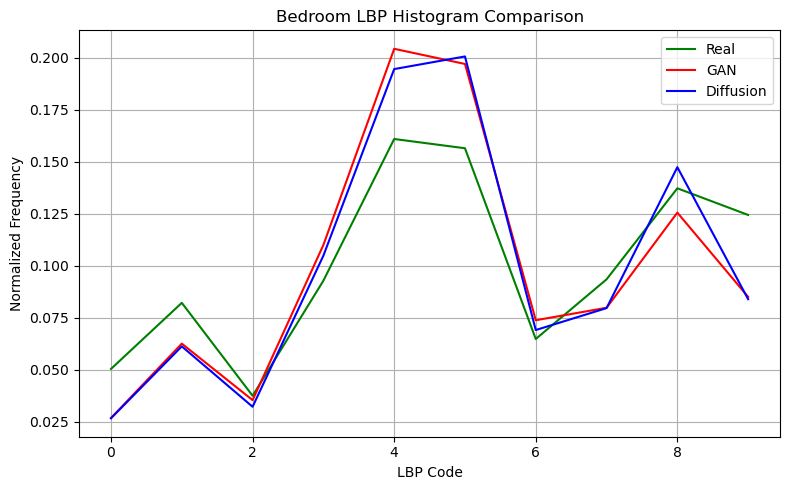

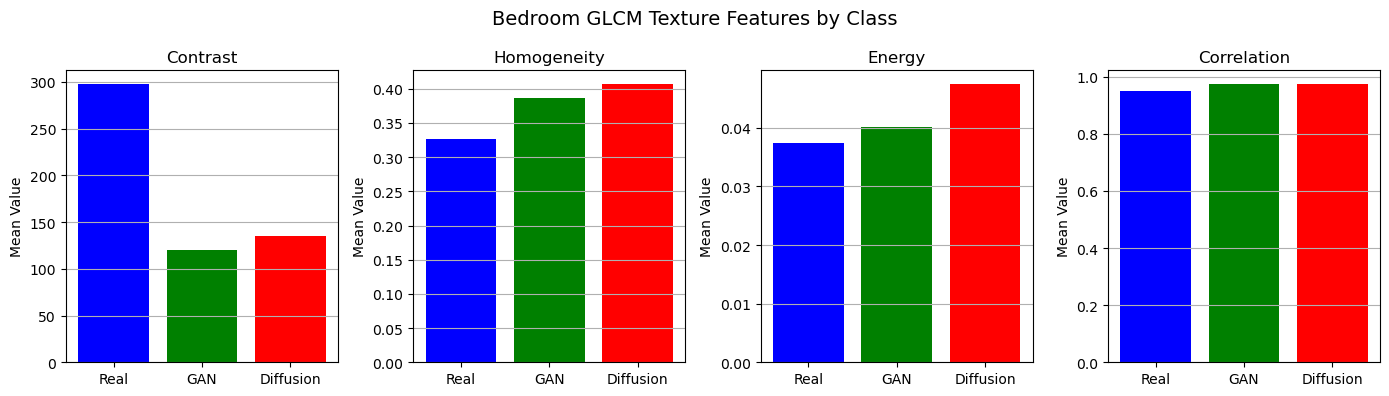

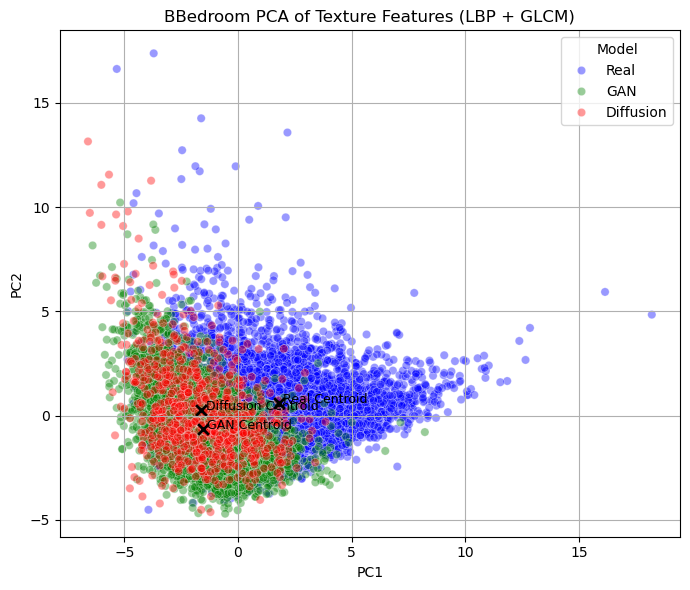

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

def extract_lbp_glcm_features(image, radius=1, n_points=8):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    glcm_feats = np.array([contrast, homogeneity, energy, correlation])
    return np.concatenate([lbp_hist, glcm_feats])

def process_folder_lbp_glcm(folder_path, label):
    features, labels = [], []
    for fname in os.listdir(folder_path):
        if not (fname.endswith(".jpg") or fname.endswith(".png")):
            continue
        path = os.path.join(folder_path, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = img.astype(np.float32) / 255.0
        feat = extract_lbp_glcm_features(img)
        features.append(feat)
        labels.append(label)
    return features, labels

def plot_lbp_glcm_pca(real_feats, gan_feats, diff_feats):
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    df = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "Model": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="Model", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    for model in ["Real", "GAN", "Diffusion"]:
        subset = df[df["Model"] == model]
        centroid = subset[["PC1", "PC2"]].mean()
        plt.scatter(centroid["PC1"], centroid["PC2"], marker='x', color='black', s=60, linewidths=2)
        plt.text(centroid["PC1"] + 0.2, centroid["PC2"], f"{model} Centroid", fontsize=9)
    plt.title("Bedroom PCA of Texture Features (LBP + GLCM)")
    plt.grid(True)
    plt.savefig("pca_lbp_glcm_bedroom.pdf")
    plt.tight_layout()
    plt.show()

def plot_lbp_histograms(real_feats, gan_feats, diff_feats, title="Bedroom LBP Histogram Comparison"):
    """
    Plot average LBP histograms for real, GAN, and diffusion images.
    """
    n_bins = len(real_feats[0]) - 4  # Last 4 elements are GLCM features
    real_lbp = np.mean([f[:n_bins] for f in real_feats], axis=0)
    gan_lbp = np.mean([f[:n_bins] for f in gan_feats], axis=0)
    diff_lbp = np.mean([f[:n_bins] for f in diff_feats], axis=0)

    x = np.arange(n_bins)
    plt.figure(figsize=(8, 5))
    plt.plot(x, real_lbp, label="Real", color="green")
    plt.plot(x, gan_lbp, label="GAN", color="red")
    plt.plot(x, diff_lbp, label="Diffusion", color="blue")
    plt.title(title)
    plt.xlabel("LBP Code")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.grid(True)
    plt.savefig("lbp_histogram_comparison_bedroom.pdf")
    plt.tight_layout()
    plt.show()

def plot_glcm_features_separate_axes(real_feats, gan_feats, diff_feats):
    """
    Plot each GLCM feature (contrast, homogeneity, energy, correlation) on its own axis.
    """
    glcm_labels = ["Contrast", "Homogeneity", "Energy", "Correlation"]
    idx = -4  # GLCM features are at the end

    real_glcm = np.mean([f[idx:] for f in real_feats], axis=0)
    gan_glcm = np.mean([f[idx:] for f in gan_feats], axis=0)
    diff_glcm = np.mean([f[idx:] for f in diff_feats], axis=0)

    fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharey=False)

    for i, label in enumerate(glcm_labels):
        axs[i].bar(["Real", "GAN", "Diffusion"], [real_glcm[i], gan_glcm[i], diff_glcm[i]],
                   color=["blue", "green", "red"])
        axs[i].set_title(label)
        axs[i].set_ylabel("Mean Value")
        axs[i].grid(axis='y')

    fig.suptitle("Bedroom GLCM Texture Features by Class", fontsize=14)
    plt.savefig("glcm_features_comparison_bedroom.pdf")
    plt.tight_layout()
    plt.show()

real_feats, _ = process_folder_lbp_glcm("../data/BEST/bedroom/real_200x200", "Real")
gan_feats, _ = process_folder_lbp_glcm("../data/BEST/bedroom/gansformer", "GAN")
diff_feats, _ = process_folder_lbp_glcm("../data/BEST/bedroom/ddpm", "Diffusion")

plot_lbp_histograms(real_feats, gan_feats, diff_feats)
plot_glcm_features_separate_axes(real_feats, gan_feats, diff_feats)
plot_lbp_glcm_pca(real_feats, gan_feats, diff_feats)



Using device: mps


/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


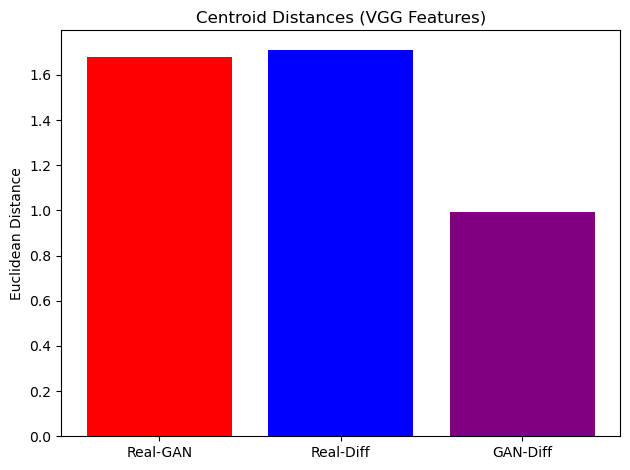

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_15618/3113542070.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")


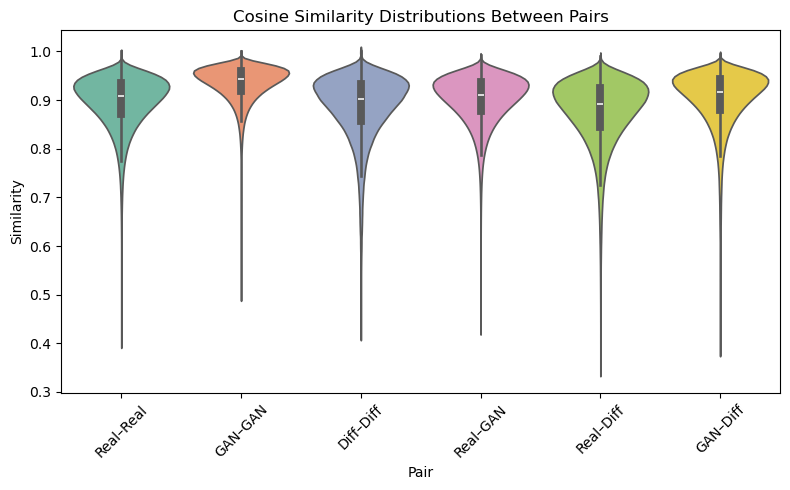

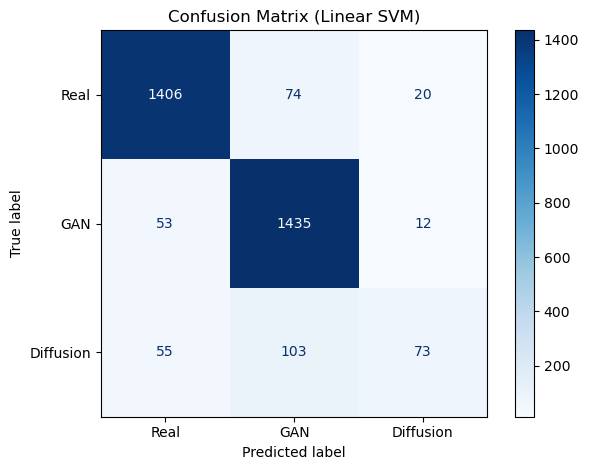

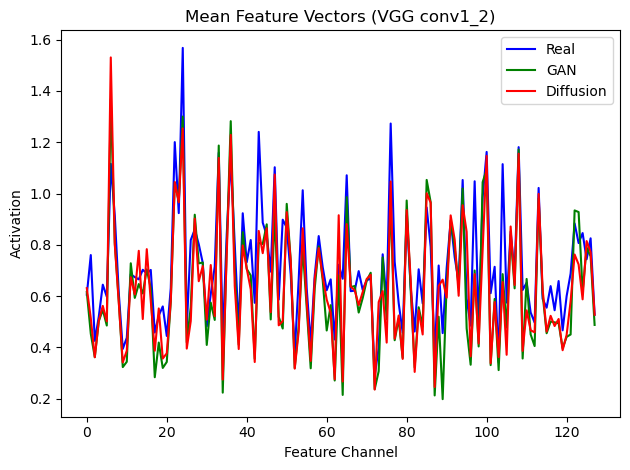

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_15618/3113542070.py:159: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")


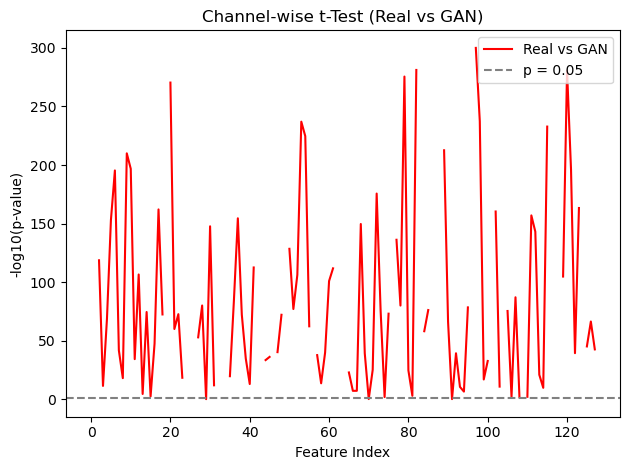

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Auto-select device (MPS for Mac, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load VGG16 and truncate to conv1_2
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()  # shape: [C, H, W]
        return feat_map.mean(dim=(1, 2)).numpy()
    except Exception as e:
        print(f"Error with {image_path}: {e}")
        return None

def process_folder(folder_path, label, max_images=None):
    feats, labels = [], []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            img_path = os.path.join(root, fname)
            feat = extract_vgg_features(img_path)
            if feat is not None:
                feats.append(feat)
                labels.append(label)
                count += 1
                if max_images and count >= max_images:
                    return feats, labels
    return feats, labels

def plot_umap(real, gan, diff, n_neighbors=15, min_dist=0.1):
    X = np.vstack([real[0], gan[0], diff[0]])
    y = real[1] + gan[1] + diff[1]

    X_scaled = StandardScaler().fit_transform(X)
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)

    df = pd.DataFrame({
        "UMAP1": X_umap[:, 0],
        "UMAP2": X_umap[:, 1],
        "Label": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    plt.title("UMAP of Deep Texture Features (VGG conv1_2)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("vgg_texture_umap.pdf")
    plt.show()

def analyze_deep_texture_features(real_feats, gan_feats, diff_feats):
    # Stack features and labels
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    df = pd.DataFrame(X)
    df["Label"] = y

    # -------- 1. Centroid distances --------
    centroids = df.groupby("Label").mean()
    dist_real_gan = np.linalg.norm(centroids.loc["Real"] - centroids.loc["GAN"])
    dist_real_diff = np.linalg.norm(centroids.loc["Real"] - centroids.loc["Diffusion"])
    dist_gan_diff = np.linalg.norm(centroids.loc["GAN"] - centroids.loc["Diffusion"])

    plt.bar(["Real-GAN", "Real-Diff", "GAN-Diff"],
            [dist_real_gan, dist_real_diff, dist_gan_diff],
            color=["red", "blue", "purple"])
    plt.ylabel("Euclidean Distance")
    plt.title("Centroid Distances (VGG Features)")
    plt.tight_layout()
    plt.show()

    # -------- 2. Cosine similarity distributions --------
    def get_pairwise_cosine_sim(feat_list_a, feat_list_b, label):
        sim_vals = []
        for a in feat_list_a:
            for b in feat_list_b:
                sim_vals.append(1 - cosine(a, b))
        return pd.DataFrame({"Similarity": sim_vals, "Pair": label})

    sims_df = pd.concat([
        get_pairwise_cosine_sim(real_feats, real_feats, "Real–Real"),
        get_pairwise_cosine_sim(gan_feats, gan_feats, "GAN–GAN"),
        get_pairwise_cosine_sim(diff_feats, diff_feats, "Diff–Diff"),
        get_pairwise_cosine_sim(real_feats, gan_feats, "Real–GAN"),
        get_pairwise_cosine_sim(real_feats, diff_feats, "Real–Diff"),
        get_pairwise_cosine_sim(gan_feats, diff_feats, "GAN–Diff"),
    ])

    plt.figure(figsize=(8, 5))
    sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")
    plt.title("Cosine Similarity Distributions Between Pairs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # -------- 3. Linear SVM classification --------
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["Real", "GAN", "Diffusion"])
    ConfusionMatrixDisplay(cm, display_labels=["Real", "GAN", "Diffusion"]).plot(cmap="Blues")
    plt.title("Confusion Matrix (Linear SVM)")
    plt.tight_layout()
    plt.show()

    # -------- 4. Average feature vectors --------
    plt.plot(centroids.columns, centroids.loc["Real"], label="Real", color="blue")
    plt.plot(centroids.columns, centroids.loc["GAN"], label="GAN", color="green")
    plt.plot(centroids.columns, centroids.loc["Diffusion"], label="Diffusion", color="red")
    plt.title("Mean Feature Vectors (VGG conv1_2)")
    plt.xlabel("Feature Channel")
    plt.ylabel("Activation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- 5. t-Test per channel --------
    p_values = []
    for i in range(X.shape[1]):
        pval = ttest_ind(real_feats, gan_feats, axis=0)[1][i]
        p_values.append(pval)

    plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")
    plt.axhline(-np.log10(0.05), linestyle="--", color="gray", label="p = 0.05")
    plt.title("Channel-wise t-Test (Real vs GAN)")
    plt.xlabel("Feature Index")
    plt.ylabel("-log10(p-value)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== 🔁 Edit paths to your dataset ==========

real_path = "../data/BEST/bedroom/real_200x200"
gan_path = "../data/BEST/bedroom/gansformer"
diff_path = "../data/BEST/bedroom/ddpm"

real_feats = process_folder(real_path, "Real")
gan_feats = process_folder(gan_path, "GAN")
diff_feats = process_folder(diff_path, "Diffusion")

plot_umap(real_feats, gan_feats, diff_feats)
analyze_deep_texture_features(real_feats[0], gan_feats[0], diff_feats[0])

## Face

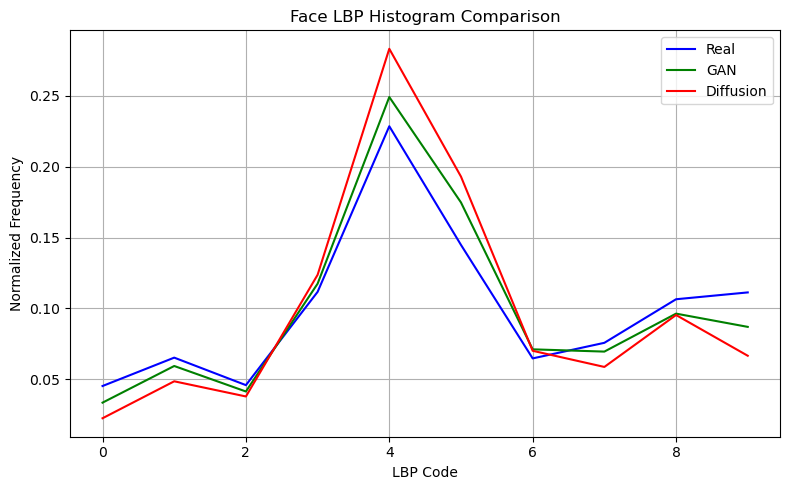

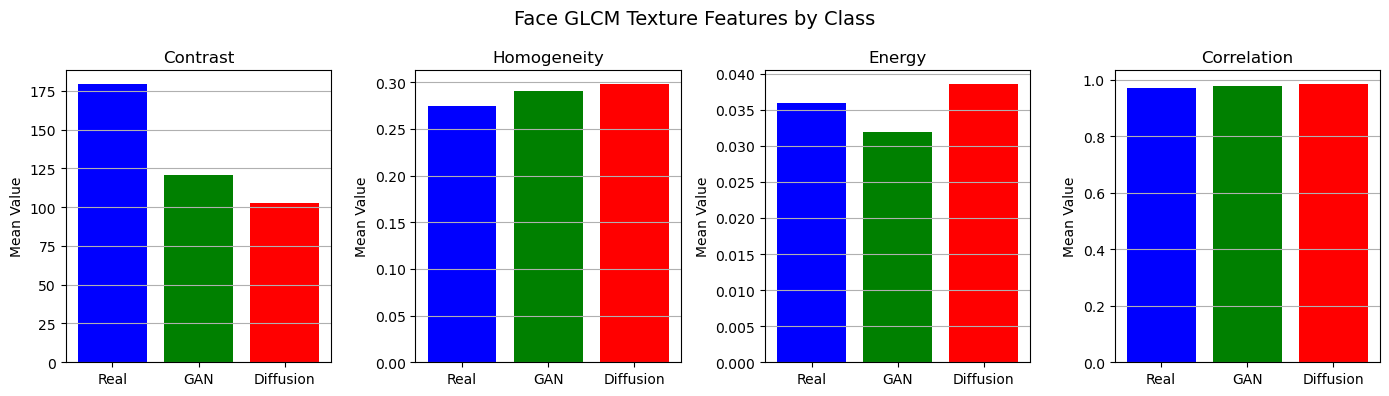

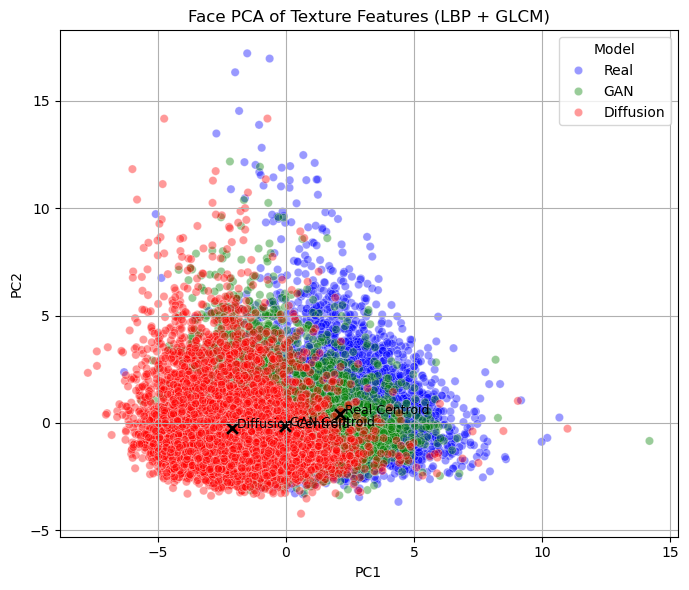

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

def extract_lbp_glcm_features(image, radius=1, n_points=8):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    glcm_feats = np.array([contrast, homogeneity, energy, correlation])
    return np.concatenate([lbp_hist, glcm_feats])

def process_folder_lbp_glcm(folder_path, label):
    features, labels = [], []
    for fname in os.listdir(folder_path):
        if not (fname.endswith(".jpg") or fname.endswith(".png")):
            continue
        path = os.path.join(folder_path, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = img.astype(np.float32) / 255.0
        feat = extract_lbp_glcm_features(img)
        features.append(feat)
        labels.append(label)
    return features, labels

def plot_lbp_glcm_pca(real_feats, gan_feats, diff_feats):
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    df = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "Model": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="Model", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    for model in ["Real", "GAN", "Diffusion"]:
        subset = df[df["Model"] == model]
        centroid = subset[["PC1", "PC2"]].mean()
        plt.scatter(centroid["PC1"], centroid["PC2"], marker='x', color='black', s=60, linewidths=2)
        plt.text(centroid["PC1"] + 0.2, centroid["PC2"], f"{model} Centroid", fontsize=9)
    plt.title("Face PCA of Texture Features (LBP + GLCM)")
    plt.grid(True)
    plt.savefig("pca_texture_features_face.pdf")
    plt.tight_layout()
    plt.show()

def plot_lbp_histograms(real_feats, gan_feats, diff_feats, title="Face LBP Histogram Comparison"):
    """
    Plot average LBP histograms for real, GAN, and diffusion images.
    """
    n_bins = len(real_feats[0]) - 4  # Last 4 elements are GLCM features
    real_lbp = np.mean([f[:n_bins] for f in real_feats], axis=0)
    gan_lbp = np.mean([f[:n_bins] for f in gan_feats], axis=0)
    diff_lbp = np.mean([f[:n_bins] for f in diff_feats], axis=0)

    x = np.arange(n_bins)
    plt.figure(figsize=(8, 5))
    plt.plot(x, real_lbp, label="Real", color="blue")
    plt.plot(x, gan_lbp, label="GAN", color="green")
    plt.plot(x, diff_lbp, label="Diffusion", color="red")
    plt.title(title)
    plt.xlabel("LBP Code")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.grid(True)
    plt.savefig("lbp_histogram_comparison_face.pdf")
    plt.tight_layout()
    plt.show()

def plot_glcm_features_separate_axes(real_feats, gan_feats, diff_feats):
    """
    Plot each GLCM feature (contrast, homogeneity, energy, correlation) on its own axis.
    """
    glcm_labels = ["Contrast", "Homogeneity", "Energy", "Correlation"]
    idx = -4  # GLCM features are at the end

    real_glcm = np.mean([f[idx:] for f in real_feats], axis=0)
    gan_glcm = np.mean([f[idx:] for f in gan_feats], axis=0)
    diff_glcm = np.mean([f[idx:] for f in diff_feats], axis=0)

    fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharey=False)

    for i, label in enumerate(glcm_labels):
        axs[i].bar(["Real", "GAN", "Diffusion"], [real_glcm[i], gan_glcm[i], diff_glcm[i]],
                   color=["blue", "green", "red"])
        axs[i].set_title(label)
        axs[i].set_ylabel("Mean Value")
        axs[i].grid(axis='y')

    fig.suptitle("Face GLCM Texture Features by Class", fontsize=14)
    plt.savefig("glcm_features_comparison_face.pdf")
    plt.tight_layout()
    plt.show()

real_feats, _ = process_folder_lbp_glcm("../data/BEST/face/real", "Real")
gan_feats, _ = process_folder_lbp_glcm("../data/BEST/face/stylegan2", "GAN")
diff_feats, _ = process_folder_lbp_glcm("../data/BEST/face/palette", "Diffusion")

plot_lbp_histograms(real_feats, gan_feats, diff_feats)
plot_glcm_features_separate_axes(real_feats, gan_feats, diff_feats)
plot_lbp_glcm_pca(real_feats, gan_feats, diff_feats)



Using device: mps


/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


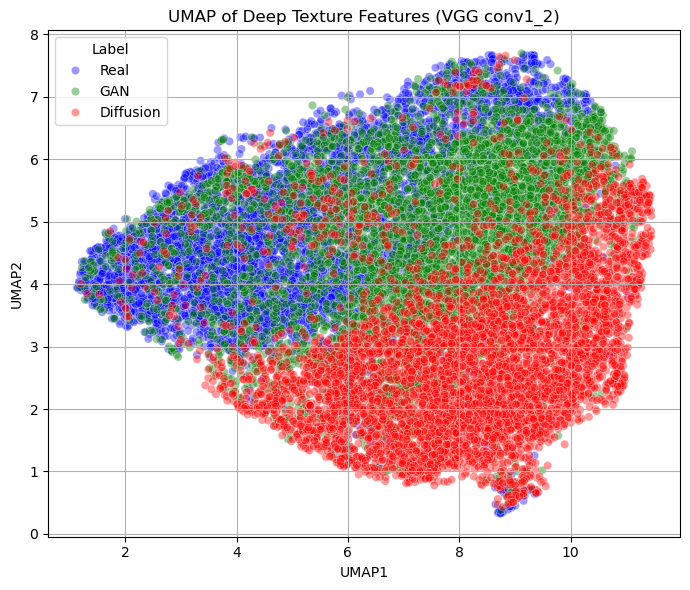

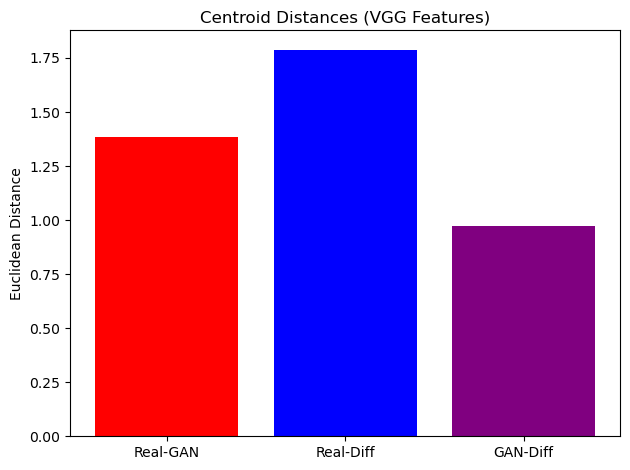

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_15618/2371211710.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")


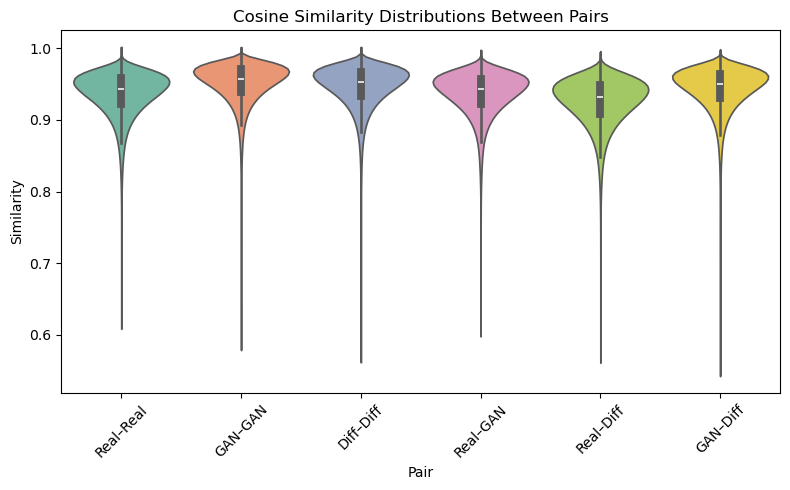

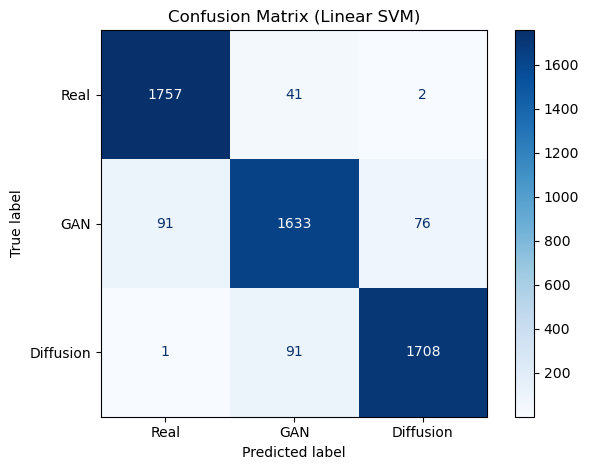

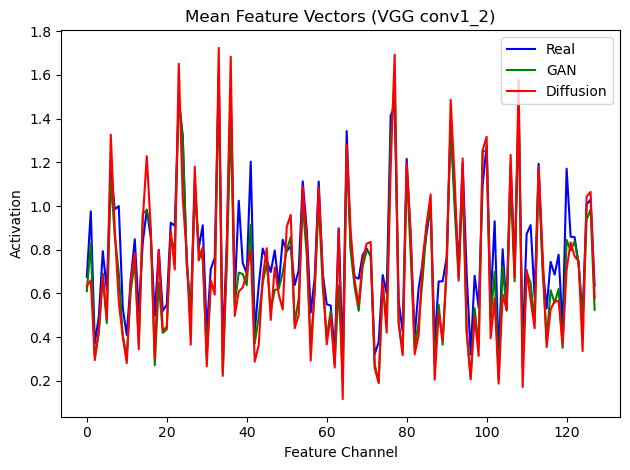

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_15618/2371211710.py:155: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")


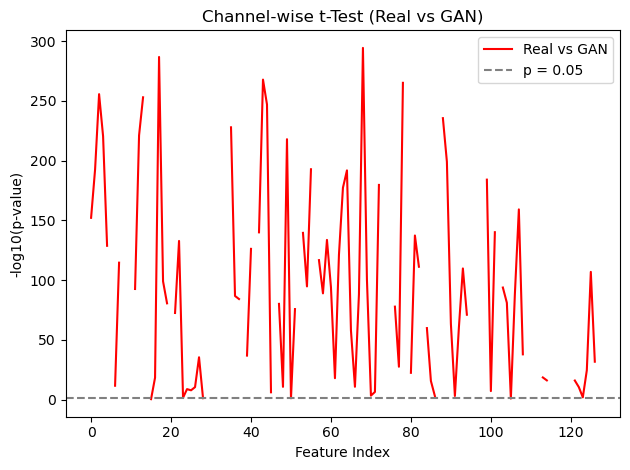

In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Auto-select device (MPS for Mac, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load VGG16 and truncate to conv1_2
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()  # shape: [C, H, W]
        return feat_map.mean(dim=(1, 2)).numpy()
    except Exception as e:
        print(f"Error with {image_path}: {e}")
        return None

def process_folder(folder_path, label, max_images=None):
    feats, labels = [], []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            img_path = os.path.join(root, fname)
            feat = extract_vgg_features(img_path)
            if feat is not None:
                feats.append(feat)
                labels.append(label)
                count += 1
                if max_images and count >= max_images:
                    return feats, labels
    return feats, labels

def plot_umap(real, gan, diff, n_neighbors=15, min_dist=0.1):
    X = np.vstack([real[0], gan[0], diff[0]])
    y = real[1] + gan[1] + diff[1]

    X_scaled = StandardScaler().fit_transform(X)
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)

    df = pd.DataFrame({
        "UMAP1": X_umap[:, 0],
        "UMAP2": X_umap[:, 1],
        "Label": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    plt.title("UMAP of Deep Texture Features (VGG conv1_2)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("vgg_texture_umap.pdf")
    plt.show()

def analyze_deep_texture_features(real_feats, gan_feats, diff_feats):
    # Stack features and labels
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    df = pd.DataFrame(X)
    df["Label"] = y

    # -------- 1. Centroid distances --------
    centroids = df.groupby("Label").mean()
    dist_real_gan = np.linalg.norm(centroids.loc["Real"] - centroids.loc["GAN"])
    dist_real_diff = np.linalg.norm(centroids.loc["Real"] - centroids.loc["Diffusion"])
    dist_gan_diff = np.linalg.norm(centroids.loc["GAN"] - centroids.loc["Diffusion"])

    plt.bar(["Real-GAN", "Real-Diff", "GAN-Diff"],
            [dist_real_gan, dist_real_diff, dist_gan_diff],
            color=["red", "blue", "purple"])
    plt.ylabel("Euclidean Distance")
    plt.title("Centroid Distances (VGG Features)")
    plt.tight_layout()
    plt.show()

    # -------- 2. Cosine similarity distributions --------
    def get_pairwise_cosine_sim(feat_list_a, feat_list_b, label):
        sim_vals = []
        for a in feat_list_a:
            for b in feat_list_b:
                sim_vals.append(1 - cosine(a, b))
        return pd.DataFrame({"Similarity": sim_vals, "Pair": label})

    sims_df = pd.concat([
        get_pairwise_cosine_sim(real_feats, real_feats, "Real–Real"),
        get_pairwise_cosine_sim(gan_feats, gan_feats, "GAN–GAN"),
        get_pairwise_cosine_sim(diff_feats, diff_feats, "Diff–Diff"),
        get_pairwise_cosine_sim(real_feats, gan_feats, "Real–GAN"),
        get_pairwise_cosine_sim(real_feats, diff_feats, "Real–Diff"),
        get_pairwise_cosine_sim(gan_feats, diff_feats, "GAN–Diff"),
    ])

    plt.figure(figsize=(8, 5))
    sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")
    plt.title("Cosine Similarity Distributions Between Pairs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # -------- 3. Linear SVM classification --------
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["Real", "GAN", "Diffusion"])
    ConfusionMatrixDisplay(cm, display_labels=["Real", "GAN", "Diffusion"]).plot(cmap="Blues")
    plt.title("Confusion Matrix (Linear SVM)")
    plt.tight_layout()
    plt.show()

    # -------- 4. Average feature vectors --------
    plt.plot(centroids.columns, centroids.loc["Real"], label="Real", color="blue")
    plt.plot(centroids.columns, centroids.loc["GAN"], label="GAN", color="green")
    plt.plot(centroids.columns, centroids.loc["Diffusion"], label="Diffusion", color="red")
    plt.title("Mean Feature Vectors (VGG conv1_2)")
    plt.xlabel("Feature Channel")
    plt.ylabel("Activation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- 5. t-Test per channel --------
    p_values = []
    for i in range(X.shape[1]):
        pval = ttest_ind(real_feats, gan_feats, axis=0)[1][i]
        p_values.append(pval)

    plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")
    plt.axhline(-np.log10(0.05), linestyle="--", color="gray", label="p = 0.05")
    plt.title("Channel-wise t-Test (Real vs GAN)")
    plt.xlabel("Feature Index")
    plt.ylabel("-log10(p-value)")
    plt.legend()
    plt.tight_layout()
    plt.show()

real_path = "../data/BEST/face/real"
gan_path = "../data/BEST/face/stylegan2"
diff_path = "../data/BEST/face/palette"

real_feats = process_folder(real_path, "Real")
gan_feats = process_folder(gan_path, "GAN")
diff_feats = process_folder(diff_path, "Diffusion")

plot_umap(real_feats, gan_feats, diff_feats)
analyze_deep_texture_features(real_feats[0], gan_feats[0], diff_feats[0])

## ImageNet

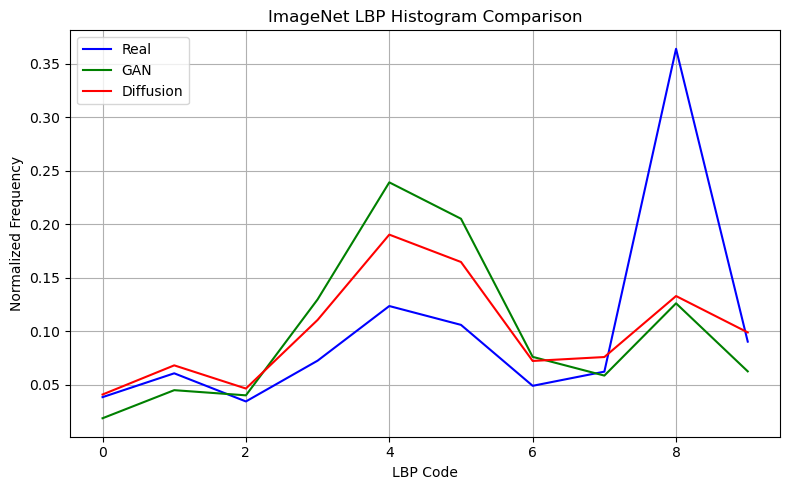

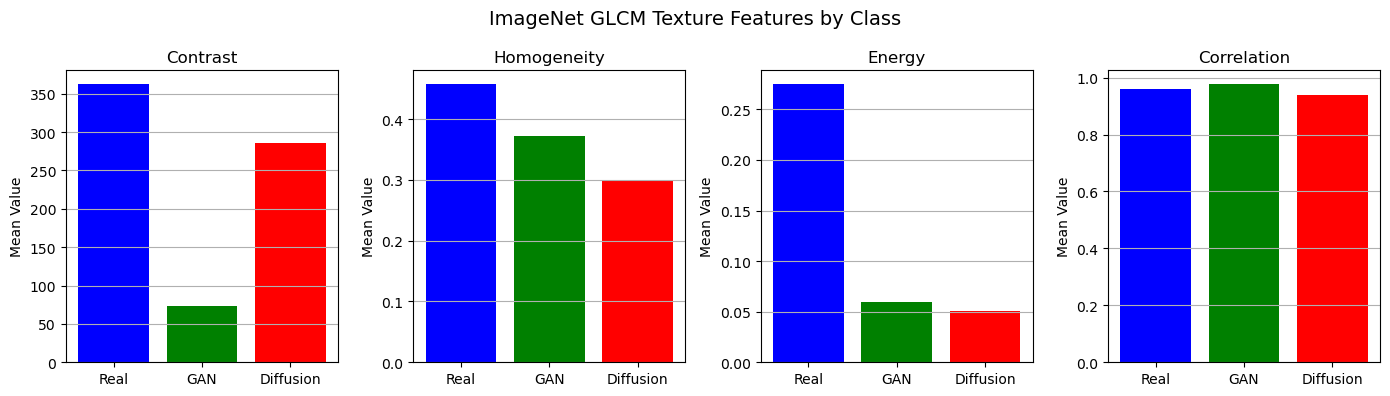

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

def extract_lbp_glcm_features(image, radius=1, n_points=8):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    glcm_feats = np.array([contrast, homogeneity, energy, correlation])
    return np.concatenate([lbp_hist, glcm_feats])

def process_folder_lbp_glcm_recursive(root_folder, label):
    """
    Recursively process all images inside subfolders of root_folder.
    Used for ImageNet-style directory structure.
    """
    features, labels = [], []
    for dirpath, _, filenames in os.walk(root_folder):
        for fname in filenames:
            if not (fname.endswith(".jpg") or fname.endswith(".png")):
                continue
            path = os.path.join(dirpath, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            feat = extract_lbp_glcm_features(img)
            features.append(feat)
            labels.append(label)
    return features, labels

def plot_lbp_glcm_pca(real_feats, gan_feats, diff_feats):
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    df = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "Model": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="Model", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    for model in ["Real", "GAN", "Diffusion"]:
        subset = df[df["Model"] == model]
        centroid = subset[["PC1", "PC2"]].mean()
        plt.scatter(centroid["PC1"], centroid["PC2"], marker='x', color='black', s=60, linewidths=2)
        plt.text(centroid["PC1"] + 0.2, centroid["PC2"], f"{model} Centroid", fontsize=9)
    plt.title("ImageNet PCA of Texture Features (LBP + GLCM)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pca_texture_features_imagenet.pdf")
    plt.show()

def plot_lbp_histograms(real_feats, gan_feats, diff_feats, title="ImageNet LBP Histogram Comparison"):
    """
    Plot average LBP histograms for real, GAN, and diffusion images.
    """
    n_bins = len(real_feats[0]) - 4  # Last 4 elements are GLCM features
    real_lbp = np.mean([f[:n_bins] for f in real_feats], axis=0)
    gan_lbp = np.mean([f[:n_bins] for f in gan_feats], axis=0)
    diff_lbp = np.mean([f[:n_bins] for f in diff_feats], axis=0)

    x = np.arange(n_bins)
    plt.figure(figsize=(8, 5))
    plt.plot(x, real_lbp, label="Real", color="blue")
    plt.plot(x, gan_lbp, label="GAN", color="green")
    plt.plot(x, diff_lbp, label="Diffusion", color="red")
    plt.title(title)
    plt.xlabel("LBP Code")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("lbp_histogram_comparison_imagenet.pdf")
    plt.show()

def plot_glcm_features_separate_axes(real_feats, gan_feats, diff_feats):
    """
    Plot each GLCM feature (contrast, homogeneity, energy, correlation) on its own axis.
    """
    glcm_labels = ["Contrast", "Homogeneity", "Energy", "Correlation"]
    idx = -4  # GLCM features are at the end

    real_glcm = np.mean([f[idx:] for f in real_feats], axis=0)
    gan_glcm = np.mean([f[idx:] for f in gan_feats], axis=0)
    diff_glcm = np.mean([f[idx:] for f in diff_feats], axis=0)

    fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharey=False)

    for i, label in enumerate(glcm_labels):
        axs[i].bar(["Real", "GAN", "Diffusion"], [real_glcm[i], gan_glcm[i], diff_glcm[i]],
                   color=["blue", "green", "red"])
        axs[i].set_title(label)
        axs[i].set_ylabel("Mean Value")
        axs[i].grid(axis='y')

    fig.suptitle("ImageNet GLCM Texture Features by Class", fontsize=14)
    plt.tight_layout()
    plt.savefig("glcm_features_comparison_imagenet.pdf")
    plt.show()

real_feats, _ = process_folder_lbp_glcm_recursive("../data/BEST/imagenet/real_imagenet", "Real")
gan_feats, _ = process_folder_lbp_glcm_recursive("../data/BEST/imagenet/big_gan", "GAN")
diff_feats, _ = process_folder_lbp_glcm_recursive("../data/BEST/imagenet/vq_diffusion", "Diffusion")

plot_lbp_histograms(real_feats, gan_feats, diff_feats)
plot_glcm_features_separate_axes(real_feats, gan_feats, diff_feats)



Using device: mps


/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


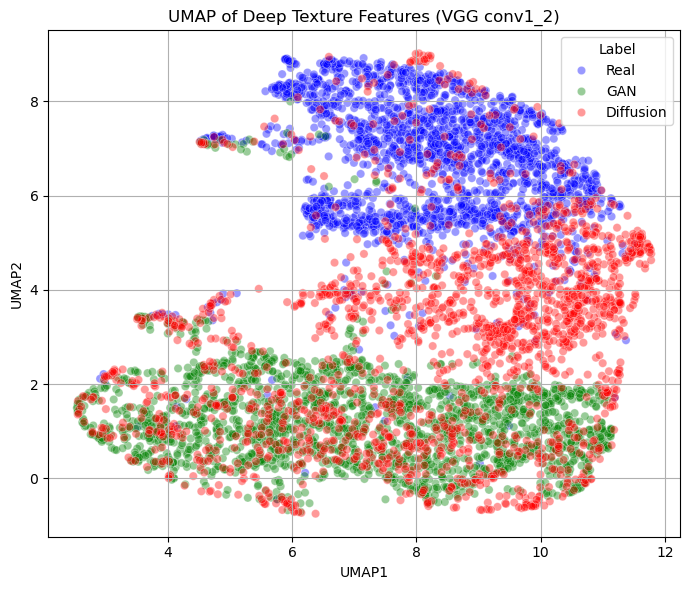

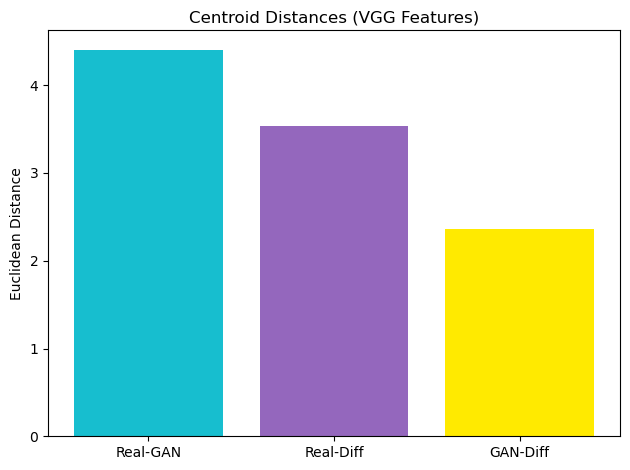

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_15618/1631009888.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")


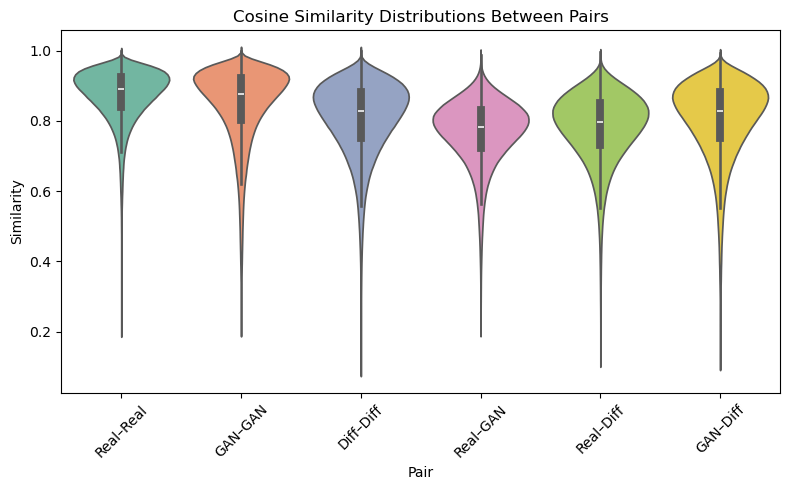

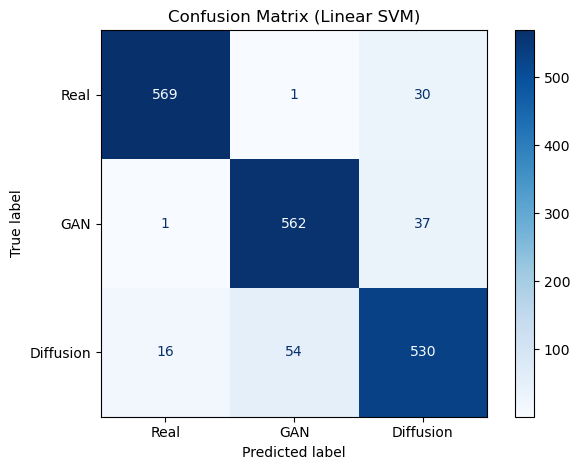

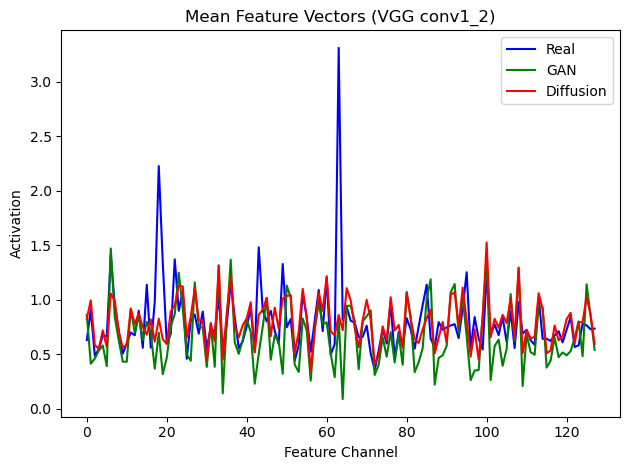

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_15618/1631009888.py:155: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")


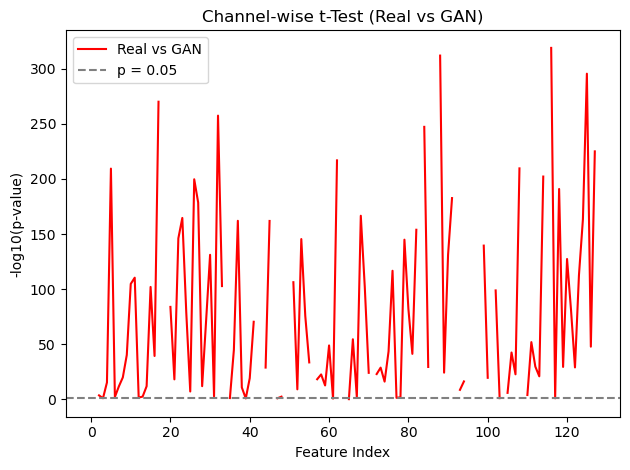

In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Auto-select device (MPS for Mac, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load VGG16 and truncate to conv1_2
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()  # shape: [C, H, W]
        return feat_map.mean(dim=(1, 2)).numpy()
    except Exception as e:
        print(f"Error with {image_path}: {e}")
        return None

def process_folder(folder_path, label, max_images=None):
    feats, labels = [], []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            img_path = os.path.join(root, fname)
            feat = extract_vgg_features(img_path)
            if feat is not None:
                feats.append(feat)
                labels.append(label)
                count += 1
                if max_images and count >= max_images:
                    return feats, labels
    return feats, labels

def plot_umap(real, gan, diff, n_neighbors=15, min_dist=0.1):
    X = np.vstack([real[0], gan[0], diff[0]])
    y = real[1] + gan[1] + diff[1]

    X_scaled = StandardScaler().fit_transform(X)
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)

    df = pd.DataFrame({
        "UMAP1": X_umap[:, 0],
        "UMAP2": X_umap[:, 1],
        "Label": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    plt.title("UMAP of Deep Texture Features (VGG conv1_2)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("vgg_texture_umap.pdf")
    plt.show()

def analyze_deep_texture_features(real_feats, gan_feats, diff_feats):
    # Stack features and labels
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    df = pd.DataFrame(X)
    df["Label"] = y

    # -------- 1. Centroid distances --------
    centroids = df.groupby("Label").mean()
    dist_real_gan = np.linalg.norm(centroids.loc["Real"] - centroids.loc["GAN"])
    dist_real_diff = np.linalg.norm(centroids.loc["Real"] - centroids.loc["Diffusion"])
    dist_gan_diff = np.linalg.norm(centroids.loc["GAN"] - centroids.loc["Diffusion"])

    plt.bar(["Real-GAN", "Real-Diff", "GAN-Diff"],
            [dist_real_gan, dist_real_diff, dist_gan_diff],
            color=['#17becf', '#9467bd', '#ffea00'])
    plt.ylabel("Euclidean Distance")
    plt.title("Centroid Distances (VGG Features)")
    plt.tight_layout()
    plt.show()

    # -------- 2. Cosine similarity distributions --------
    def get_pairwise_cosine_sim(feat_list_a, feat_list_b, label):
        sim_vals = []
        for a in feat_list_a:
            for b in feat_list_b:
                sim_vals.append(1 - cosine(a, b))
        return pd.DataFrame({"Similarity": sim_vals, "Pair": label})

    sims_df = pd.concat([
        get_pairwise_cosine_sim(real_feats, real_feats, "Real–Real"),
        get_pairwise_cosine_sim(gan_feats, gan_feats, "GAN–GAN"),
        get_pairwise_cosine_sim(diff_feats, diff_feats, "Diff–Diff"),
        get_pairwise_cosine_sim(real_feats, gan_feats, "Real–GAN"),
        get_pairwise_cosine_sim(real_feats, diff_feats, "Real–Diff"),
        get_pairwise_cosine_sim(gan_feats, diff_feats, "GAN–Diff"),
    ])

    plt.figure(figsize=(8, 5))
    sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")
    plt.title("Cosine Similarity Distributions Between Pairs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # -------- 3. Linear SVM classification --------
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["Real", "GAN", "Diffusion"])
    ConfusionMatrixDisplay(cm, display_labels=["Real", "GAN", "Diffusion"]).plot(cmap="Blues")
    plt.title("Confusion Matrix (Linear SVM)")
    plt.tight_layout()
    plt.show()

    # -------- 4. Average feature vectors --------
    plt.plot(centroids.columns, centroids.loc["Real"], label="Real", color="blue")
    plt.plot(centroids.columns, centroids.loc["GAN"], label="GAN", color="green")
    plt.plot(centroids.columns, centroids.loc["Diffusion"], label="Diffusion", color="red")
    plt.title("Mean Feature Vectors (VGG conv1_2)")
    plt.xlabel("Feature Channel")
    plt.ylabel("Activation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- 5. t-Test per channel --------
    p_values = []
    for i in range(X.shape[1]):
        pval = ttest_ind(real_feats, gan_feats, axis=0)[1][i]
        p_values.append(pval)

    plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")
    plt.axhline(-np.log10(0.05), linestyle="--", color="gray", label="p = 0.05")
    plt.title("Channel-wise t-Test (Real vs GAN)")
    plt.xlabel("Feature Index")
    plt.ylabel("-log10(p-value)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== 🔁 Edit paths to your dataset ==========

real_path = "../data/BEST/imagenet/real_imagenet"
gan_path = "../data/BEST/imagenet/big_gan"
diff_path = "../data/BEST/imagenet/vq_diffusion"

real_feats = process_folder(real_path, "Real", max_images=2000)
gan_feats = process_folder(gan_path, "GAN", max_images=2000)
diff_feats = process_folder(diff_path, "Diffusion", max_images=2000)

plot_umap(real_feats, gan_feats, diff_feats)
analyze_deep_texture_features(real_feats[0], gan_feats[0], diff_feats[0])

## Overall Deep Texture Features Results

Using device: mps


/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/recipemag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


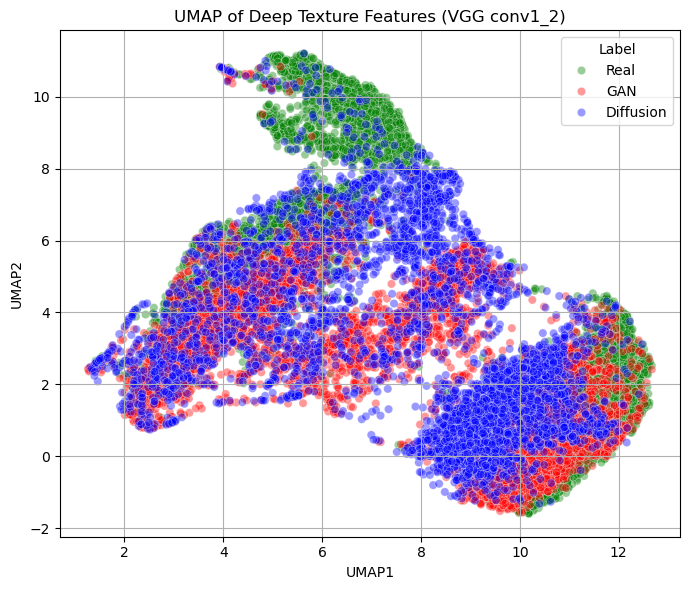

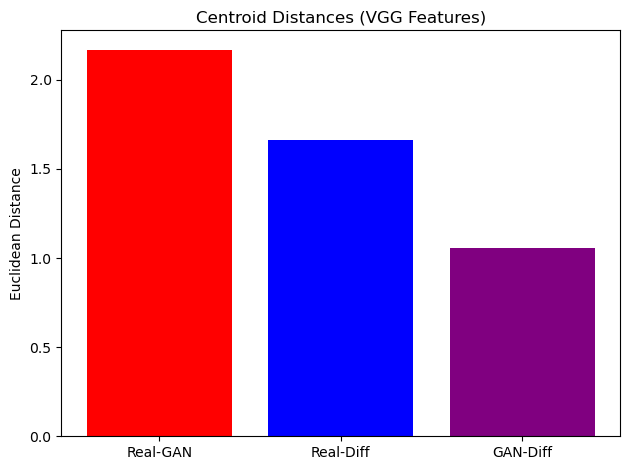

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_57658/177439565.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")


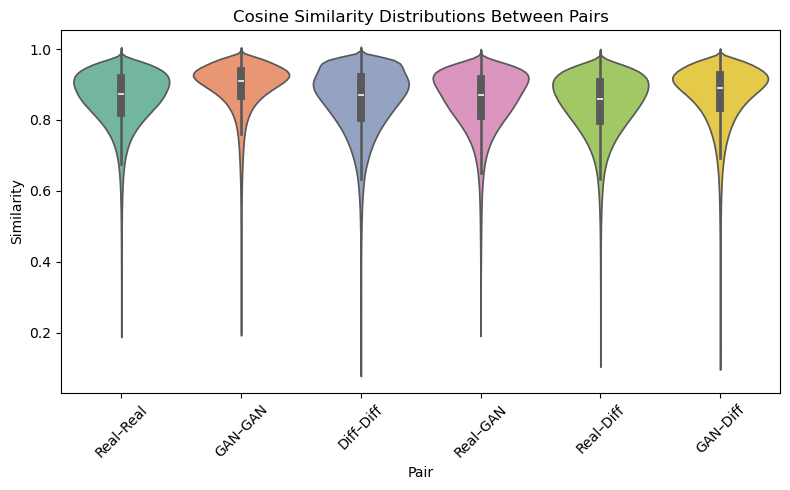

[LibSVM]........................................*...........................*.............................*...........*
optimization finished, #iter = 106480
obj = -3358.394961, rho = -7.024188
nSV = 3570, nBSV = 3465
....................................*...............................*.............................*
optimization finished, #iter = 95526
obj = -1462.077814, rho = -2.784944
nSV = 1626, nBSV = 1520
..........................*............................*...............*.*
optimization finished, #iter = 69374
obj = -1569.404399, rho = -6.992141
nSV = 1749, nBSV = 1642
Total nSV = 5536


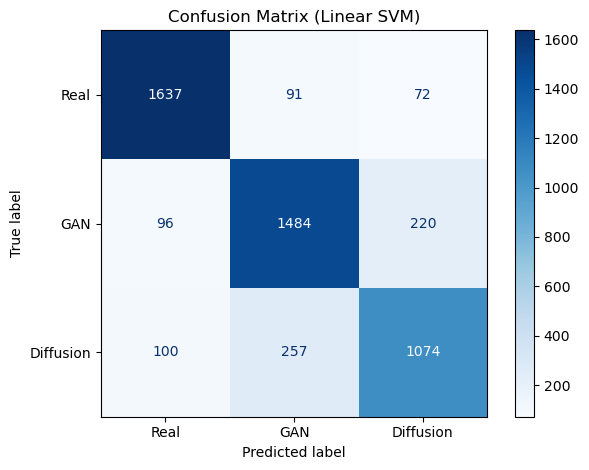

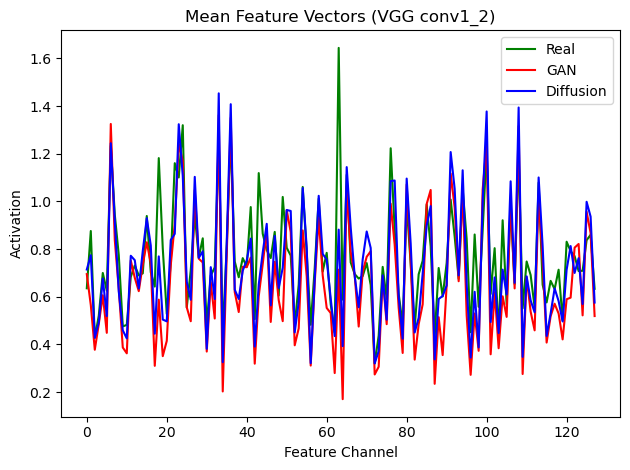

/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_57658/177439565.py:167: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")


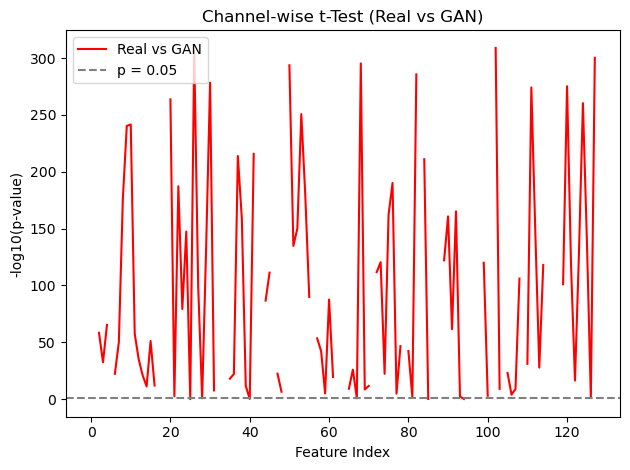

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

from torchvision import models, transforms
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Auto-select device (MPS for Mac, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load VGG16 and truncate to conv1_2
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()  # shape: [C, H, W]
        return feat_map.mean(dim=(1, 2)).numpy()
    except Exception as e:
        print(f"Error with {image_path}: {e}")
        return None

def process_folder(folder_path, label, max_images=None):
    feats, labels = [], []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            img_path = os.path.join(root, fname)
            feat = extract_vgg_features(img_path)
            if feat is not None:
                feats.append(feat)
                labels.append(label)
                count += 1
                if max_images and count >= max_images:
                    return feats, labels
    return feats, labels

def process_multiple_folders(folders, label, max_images=None):
    all_feats, all_labels = [], []
    for folder in folders:
        feats, labels = process_folder(folder, label, max_images=max_images)
        all_feats.extend(feats)
        all_labels.extend(labels)
    return all_feats, all_labels

def plot_umap(real, gan, diff, n_neighbors=15, min_dist=0.1):
    X = np.vstack([real[0], gan[0], diff[0]])
    y = real[1] + gan[1] + diff[1]

    X_scaled = StandardScaler().fit_transform(X)
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)

    df = pd.DataFrame({
        "UMAP1": X_umap[:, 0],
        "UMAP2": X_umap[:, 1],
        "Label": y
    })

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", alpha=0.4,
                    palette={"Real": "blue", "GAN": "green", "Diffusion": "red"})
    plt.title("UMAP of Deep Texture Features (VGG conv1_2)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("vgg_texture_umap.pdf")
    plt.show()

def analyze_deep_texture_features(real_feats, gan_feats, diff_feats):
    # Stack features and labels
    X = np.vstack([real_feats, gan_feats, diff_feats])
    y = ["Real"] * len(real_feats) + ["GAN"] * len(gan_feats) + ["Diffusion"] * len(diff_feats)

    df = pd.DataFrame(X)
    df["Label"] = y

    # -------- 1. Centroid distances --------
    centroids = df.groupby("Label").mean()
    dist_real_gan = np.linalg.norm(centroids.loc["Real"] - centroids.loc["GAN"])
    dist_real_diff = np.linalg.norm(centroids.loc["Real"] - centroids.loc["Diffusion"])
    dist_gan_diff = np.linalg.norm(centroids.loc["GAN"] - centroids.loc["Diffusion"])

    plt.bar(["Real-GAN", "Real-Diff", "GAN-Diff"],
            [dist_real_gan, dist_real_diff, dist_gan_diff],
            color=["red", "blue", "purple"])
    plt.ylabel("Euclidean Distance")
    plt.title("Centroid Distances (VGG Features)")
    plt.tight_layout()
    plt.show()

    # -------- 2. Cosine similarity distributions --------
    def get_pairwise_cosine_sim(feat_list_a, feat_list_b, label):
        sim_vals = []
        for a in feat_list_a:
            for b in feat_list_b:
                sim_vals.append(1 - cosine(a, b))
        return pd.DataFrame({"Similarity": sim_vals, "Pair": label})

    sims_df = pd.concat([
        get_pairwise_cosine_sim(real_feats, real_feats, "Real–Real"),
        get_pairwise_cosine_sim(gan_feats, gan_feats, "GAN–GAN"),
        get_pairwise_cosine_sim(diff_feats, diff_feats, "Diff–Diff"),
        get_pairwise_cosine_sim(real_feats, gan_feats, "Real–GAN"),
        get_pairwise_cosine_sim(real_feats, diff_feats, "Real–Diff"),
        get_pairwise_cosine_sim(gan_feats, diff_feats, "GAN–Diff"),
    ])

    plt.figure(figsize=(8, 5))
    sns.violinplot(data=sims_df, x="Pair", y="Similarity", palette="Set2")
    plt.title("Cosine Similarity Distributions Between Pairs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # -------- 3. Linear SVM classification --------
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf = SVC(kernel="linear", verbose=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["Real", "GAN", "Diffusion"])
    ConfusionMatrixDisplay(cm, display_labels=["Real", "GAN", "Diffusion"]).plot(cmap="Blues")
    plt.title("Confusion Matrix (Linear SVM)")
    plt.tight_layout()
    plt.show()

    # -------- 4. Average feature vectors --------
    plt.plot(centroids.columns, centroids.loc["Real"], label="Real", color="blue")
    plt.plot(centroids.columns, centroids.loc["GAN"], label="GAN", color="green")
    plt.plot(centroids.columns, centroids.loc["Diffusion"], label="Diffusion", color="red")
    plt.title("Mean Feature Vectors (VGG conv1_2)")
    plt.xlabel("Feature Channel")
    plt.ylabel("Activation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- 5. t-Test per channel --------
    p_values = []
    for i in range(X.shape[1]):
        pval = ttest_ind(real_feats, gan_feats, axis=0)[1][i]
        p_values.append(pval)

    plt.plot(range(len(p_values)), -np.log10(p_values), label="Real vs GAN", color="red")
    plt.axhline(-np.log10(0.05), linestyle="--", color="gray", label="p = 0.05")
    plt.title("Channel-wise t-Test (Real vs GAN)")
    plt.xlabel("Feature Index")
    plt.ylabel("-log10(p-value)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== 🔁 Edit paths to your dataset ==========

real_folders = [
    "../data/BEST/bedroom/real_200x200",
    "../data/BEST/face/real",
    "../data/BEST/imagenet/real_imagenet"
]
gan_folders = [
    "../data/BEST/bedroom/gansformer",
    "../data/BEST/face/stylegan2",
    "../data/BEST/imagenet/big_gan"
]
diff_folders = [
    "../data/BEST/bedroom/ddpm",
    "../data/BEST/face/palette",
    "../data/BEST/imagenet/vq_diffusion"
]

real_feats = process_multiple_folders(real_folders, "Real", max_images=2000)
gan_feats = process_multiple_folders(gan_folders, "GAN", max_images=2000)
diff_feats = process_multiple_folders(diff_folders, "Diffusion", max_images=2000)

plot_umap(real_feats, gan_feats, diff_feats)
analyze_deep_texture_features(real_feats[0], gan_feats[0], diff_feats[0])

# Qualitative examples

### Bedroom examples

In [86]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

# --- GLCM Feature Computation ---
def compute_glcm_features(image, distances=[1], angles=[0]):
    image = cv2.resize(image, (128, 128)).astype(np.uint8)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return np.array([contrast, homogeneity, energy, correlation])

# --- Dataset Extraction ---
def extract_glcm_from_folder(folder_path, label, max_images=300):
    data = []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            path = os.path.join(root, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            features = compute_glcm_features(img)
            data.append({
                "path": path,
                "label": label,
                "contrast": features[0],
                "homogeneity": features[1],
                "energy": features[2],
                "correlation": features[3]
            })
            count += 1
            if count >= max_images:
                break
    return pd.DataFrame(data)

# --- Update these to your actual dataset paths ---
real_path = "../data/BEST/bedroom/real_200x200"
gan_path = "../data/BEST/bedroom/gansformer"
diff_path = "../data/BEST/bedroom/ddpm"

# --- Run feature extraction ---
real_df = extract_glcm_from_folder(real_path, "Real")
gan_df = extract_glcm_from_folder(gan_path, "GAN")
diff_df = extract_glcm_from_folder(diff_path, "Diffusion")

# --- Combine all samples ---
all_df = pd.concat([real_df, gan_df, diff_df], ignore_index=True)

# --- Select top examples for qualitative visualization ---
top_real = all_df[all_df["label"] == "Real"].sort_values(by="contrast", ascending=False).head(0)
low_gan = all_df[all_df["label"] == "GAN"].sort_values(by="contrast", ascending=True).head(0)
low_diff = all_df[all_df["label"] == "Diffusion"].sort_values(by="contrast", ascending=True).head(100)

# --- Combine selected samples ---
qualitative_df = pd.concat([top_real, low_gan, low_diff], ignore_index=True)

pd.set_option("display.max_colwidth", None)

# --- Display or export ---
qualitative_df[["label", "path", "contrast"]].head(100)  # Display first 30 rows

label                                     path    contrast
0   Diffusion  ../data/BEST/bedroom/ddpm/img000315.jpg   10.946912
1   Diffusion  ../data/BEST/bedroom/ddpm/img000498.jpg   11.614419
2   Diffusion  ../data/BEST/bedroom/ddpm/img000412.jpg   13.323327
3   Diffusion  ../data/BEST/bedroom/ddpm/img000361.jpg   13.623339
4   Diffusion  ../data/BEST/bedroom/ddpm/img000501.jpg   15.638349
..        ...                                      ...         ...
95  Diffusion  ../data/BEST/bedroom/ddpm/img000129.jpg  116.233206
96  Diffusion  ../data/BEST/bedroom/ddpm/img000529.jpg  116.644931
97  Diffusion  ../data/BEST/bedroom/ddpm/img000702.jpg  118.550258
98  Diffusion  ../data/BEST/bedroom/ddpm/img000513.jpg  120.957124
99  Diffusion  ../data/BEST/bedroom/ddpm/img000364.jpg  122.495202

[100 rows x 3 columns]

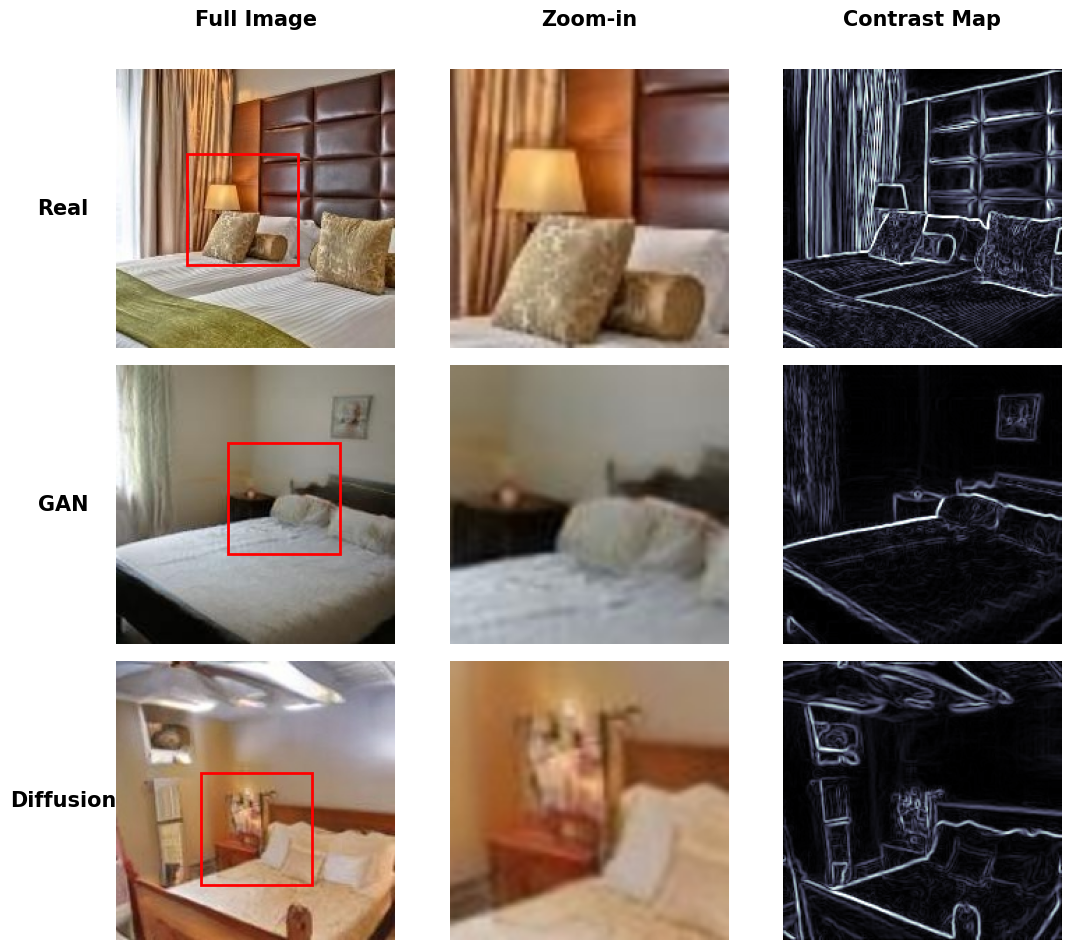

In [104]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_texture_grid_labeled(image_paths, labels, zoom_boxes, save_path=None):
    """
    3 rows (Real, GAN, Diffusion) × 4 columns (Image, Zoom, Contrast, Variance)
    Adds one title row and one label column.
    """
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(nrows=4, ncols=5, width_ratios=[0.12, 1, 1, 1, 1], height_ratios=[0.08, 1, 1, 1])
    column_titles = ["Full Image", "Zoom-in", "Contrast Map"]

    # Top column headers
    for i, title in enumerate(column_titles):
        ax = fig.add_subplot(gs[0, i + 1])  # +1 to skip label column
        ax.set_title(title, fontsize=15, weight='bold', pad=2)
        ax.axis("off")

    # Add empty header for the first (label) column for visual balance
    ax = fig.add_subplot(gs[0, 0])
    ax.axis("off")

    for row, (path, label, zoom_box) in enumerate(zip(image_paths, labels, zoom_boxes)):
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Could not load image: {path}")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        x, y, w, h = zoom_box

        # Row label
        ax_label = fig.add_subplot(gs[row + 1, 0])
        ax_label.text(0.5, 0.5, label, ha='center', va='center', fontsize=15, weight='bold')
        ax_label.axis("off")

        # Full image
        ax_img = fig.add_subplot(gs[row + 1, 1])
        ax_img.imshow(img_rgb)
        ax_img.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
        ax_img.axis("off")

        # Zoom-in
        zoom_crop = img_rgb[y:y+h, x:x+w]
        zoom_resized = cv2.resize(zoom_crop, (w * 2, h * 2), interpolation=cv2.INTER_LINEAR)
        ax_zoom = fig.add_subplot(gs[row + 1, 2])
        ax_zoom.imshow(zoom_resized)
        ax_zoom.axis("off")

        # Contrast map
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        ax_contrast = fig.add_subplot(gs[row + 1, 3])
        ax_contrast.imshow(magnitude, cmap='bone', vmin=0, vmax=500)
        ax_contrast.axis("off")

    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.04, wspace=0.05, hspace=0.08)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
plot_texture_grid_labeled(
    image_paths=[
        "../data/BEST/bedroom/real_200x200/fe9a2719febad608626ff40412afaff686a61f12.jpg",
       "../data/BEST/bedroom/gansformer/img000809.jpg",
        "../data/BEST/bedroom/ddpm/img000529.jpg"
    ],
    labels=["Real", "GAN", "Diffusion"],
    zoom_boxes=[
        (50, 60, 80, 80),   # Real
        (80, 55, 80, 80),   # GAN
        (60, 80, 80, 80)    # Diffusion
    ],
    save_path="texture_comparison_bedroom.pdf"
)

### Face examples

In [38]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

# --- GLCM Feature Computation ---
def compute_glcm_features(image, distances=[1], angles=[0]):
    image = cv2.resize(image, (128, 128)).astype(np.uint8)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return np.array([contrast, homogeneity, energy, correlation])

# --- Dataset Extraction ---
def extract_glcm_from_folder(folder_path, label, max_images=300):
    data = []
    count = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            path = os.path.join(root, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            features = compute_glcm_features(img)
            data.append({
                "path": path,
                "label": label,
                "contrast": features[0],
                "homogeneity": features[1],
                "energy": features[2],
                "correlation": features[3]
            })
            count += 1
            if count >= max_images:
                break
    return pd.DataFrame(data)

# --- Update these to your actual dataset paths ---
real_path = "../data/BEST/face/real"
gan_path = "../data/BEST/face/stylegan2"
diff_path = "../data/BEST/face/palette"

# --- Run feature extraction ---
real_df = extract_glcm_from_folder(real_path, "Real")
gan_df = extract_glcm_from_folder(gan_path, "GAN")
diff_df = extract_glcm_from_folder(diff_path, "Diffusion")

# --- Combine all samples ---
all_df = pd.concat([real_df, gan_df, diff_df], ignore_index=True)

# --- Select top examples for qualitative visualization ---
top_real = all_df[all_df["label"] == "Real"].sort_values(by="contrast", ascending=False).head(10)
low_gan = all_df[all_df["label"] == "GAN"].sort_values(by="contrast", ascending=True).head(10)
low_diff = all_df[all_df["label"] == "Diffusion"].sort_values(by="contrast", ascending=True).head(10)

# --- Combine selected samples ---
qualitative_df = pd.concat([top_real, low_gan, low_diff], ignore_index=True)

# --- Display or export ---
print(qualitative_df[["label", "path", "contrast"]])

        label                                       path    contrast
0        Real           ../data/BEST/face/real/48163.png  564.597256
1        Real           ../data/BEST/face/real/26240.png  512.517840
2        Real           ../data/BEST/face/real/28325.png  497.523438
3        Real           ../data/BEST/face/real/01577.png  488.409326
4        Real           ../data/BEST/face/real/39942.png  486.327694
5        Real           ../data/BEST/face/real/12126.png  469.215674
6        Real           ../data/BEST/face/real/38693.png  454.692052
7        Real           ../data/BEST/face/real/11412.png  447.351686
8        Real           ../data/BEST/face/real/30224.png  438.350578
9        Real           ../data/BEST/face/real/16341.png  436.720103
10        GAN  ../data/BEST/face/stylegan2/img093292.jpg   54.522146
11        GAN  ../data/BEST/face/stylegan2/img056871.jpg   59.706139
12        GAN  ../data/BEST/face/stylegan2/img095191.jpg   60.270362
13        GAN  ../data/BEST/face/s

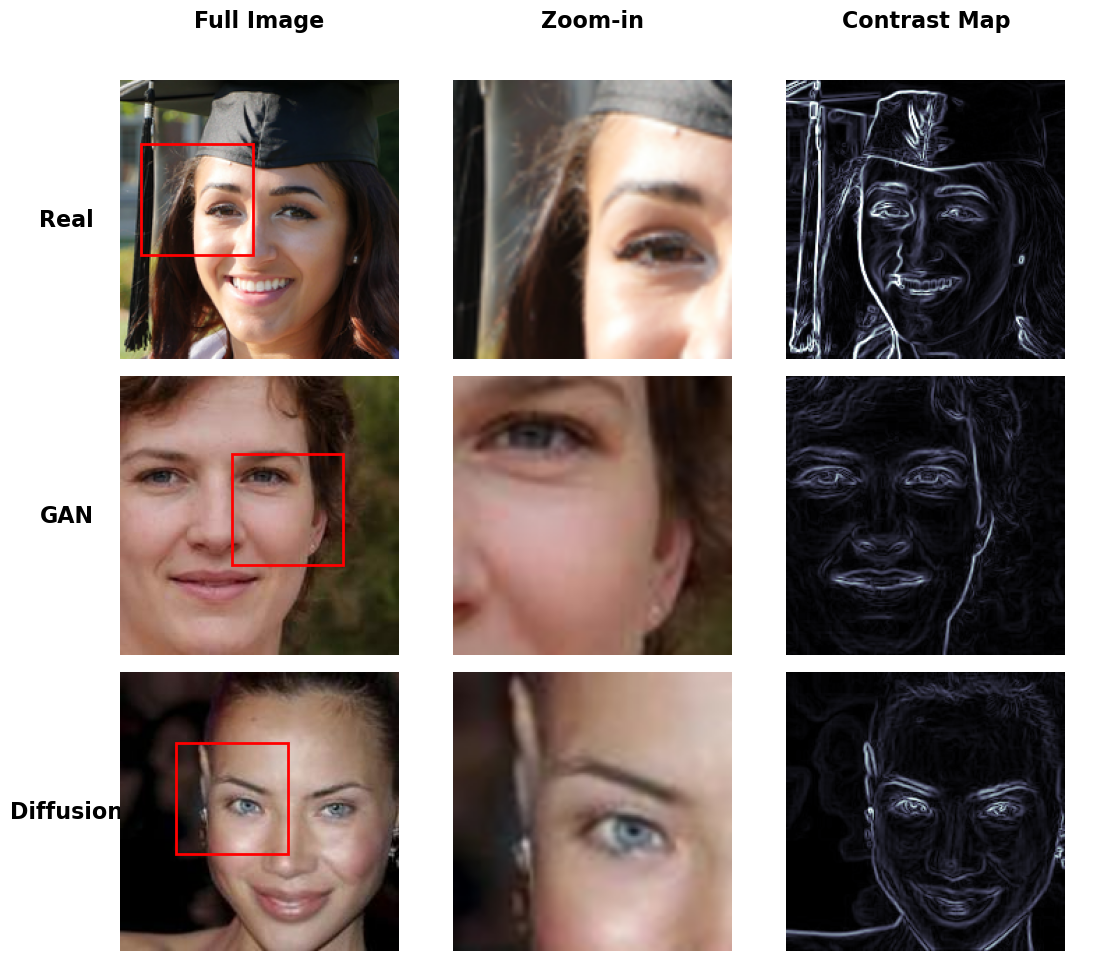

In [96]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_texture_grid_labeled(image_paths, labels, zoom_boxes, save_path=None):
    """
    3 rows (Real, GAN, Diffusion) × 4 columns (Image, Zoom, Contrast, Variance)
    Adds one title row and one label column.
    """
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(nrows=4, ncols=5, width_ratios=[0.12, 1, 1, 1, 1], height_ratios=[0.08, 1, 1, 1])
    column_titles = ["Full Image", "Zoom-in", "Contrast Map"]

    # Top column headers
    for i, title in enumerate(column_titles):
        ax = fig.add_subplot(gs[0, i + 1])
        ax.set_title(title, fontsize=16, weight='bold', pad=10)
        ax.axis("off")

    for row, (path, label, zoom_box) in enumerate(zip(image_paths, labels, zoom_boxes)):
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Could not load image: {path}")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        x, y, w, h = zoom_box

        # Row label
        ax_label = fig.add_subplot(gs[row + 1, 0])
        ax_label.text(0.5, 0.5, label, ha='center', va='center', fontsize=16, weight='bold')
        ax_label.axis("off")

        # Full image
        ax_img = fig.add_subplot(gs[row + 1, 1])
        ax_img.imshow(img_rgb)
        ax_img.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
        ax_img.axis("off")

        # Zoom-in
        zoom_crop = img_rgb[y:y+h, x:x+w]
        zoom_resized = cv2.resize(zoom_crop, (w * 2, h * 2), interpolation=cv2.INTER_LINEAR)
        ax_zoom = fig.add_subplot(gs[row + 1, 2])
        ax_zoom.imshow(zoom_resized)
        ax_zoom.axis("off")

        # Contrast map
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        ax_contrast = fig.add_subplot(gs[row + 1, 3])
        ax_contrast.imshow(magnitude, cmap='bone', vmin=0, vmax=500)
        ax_contrast.axis("off")

    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.04, wspace=0.05, hspace=0.08)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_texture_grid_labeled(
    image_paths=[
        "../data/BEST/face/real/30224.png",
        "../data/BEST/face/stylegan2/img093292.jpg",
        "../data/BEST/face/palette/img000607.jpg"
    ],
    labels=["Real", "GAN", "Diffusion"],
    zoom_boxes=[
        (15, 45, 80, 80),   # Real
        (80, 55, 80, 80),   # GAN
        (40, 50, 80, 80)    # Diffusion
    ],
    save_path="texture_comparison_face.pdf"
)